In [211]:
import tweepy
import json
import re
import arrow
import hdbscan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime
from pytz import timezone
from dateutil.parser import parse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import davies_bouldin_score
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from nltk.corpus import stopwords

stop_words = stopwords.words("english")

In [212]:
trump = pd.read_csv('trump_basic_sentiment.csv')
trump.head()

,id,created_at,source,year,month,day,hour,day_of_week,week,is_reply,...,text_cleaned,tb_polarity,tb_subjectivity,tb_orientation,tb_explanatory,vd_neg,vd_neu,vd_pos,vd_compound,vd_orientation
0,1256024228777857025,Fri May 01 00:54:46 +0000 2020,Twitter for iPhone,2020,4,30,20,4,17,False,...,the only thing get wrong be that be even bad t...,-0.412500,0.825000,negative,subjective,0.373,0.627,0.000,-0.8786,negative
1,1256016249169084417,Fri May 01 00:23:04 +0000 2020,Twitter for iPhone,2020,4,30,20,4,17,False,...,vote by may opponent vote to fire teacher and ...,1.000000,0.750000,positive,subjective,0.205,0.671,0.123,-0.4168,negative
2,1256013240896835585,Fri May 01 00:11:06 +0000 2020,Twitter for iPhone,2020,4,30,20,4,17,True,...,be strong on crime the border and second amend...,0.088889,0.397222,positive,objective,0.072,0.740,0.189,0.6885,positive
3,1256013239487549441,Fri May 01 00:11:06 +0000 2020,Twitter for iPhone,2020,4,30,20,4,17,False,...,tom tiffany be a great advocate for the incred...,0.541667,0.633333,positive,subjective,0.046,0.640,0.314,0.9439,positive
4,1255926261068763143,Thu Apr 30 18:25:29 +0000 2020,Twitter for iPhone,2020,4,30,14,4,17,False,...,over million economic impact payment have alre...,0.250000,0.400000,positive,objective,0.000,1.000,0.000,0.0000,neutral


In [213]:
corpus = trump['text_cleaned'].str.replace('democrats', 'democrat').values
corpus

array(['the only thing get wrong be that be even bad the corruption than think jordan dirty cops',
       'vote by may opponent vote to fire teacher and cut salary while bump up pay now mock great vet need navy fighter pilot mike garcia in',
       'be strong on crime the border and second amendment tom have deep root in wisconsin be a big tax cutter and will help drain the swamp tom have complete and total endorsement vote for tom tiffany',
       ..., 'everyone very excited about the new deal with mexico',
       'nervous nancy pelosi the democrat house be get nothing do perhaps could lead the way with the usmca the spectacular very popular new trade deal that replace nafta the bad trade deal in the history of the u s a great for farmer manufacturer union',
       'mexico have agree to immediately begin buy large quantity of agricultural product from great patriot farmer'],
      dtype=object)

In [214]:
# tf idf 
vectorizer = TfidfVectorizer(
    min_df = 5,
    stop_words = 'english' # remove stop words
)
tfidf = vectorizer.fit_transform(corpus)
tfidf.shape

(4739, 1849)

# k-means

In [207]:
# MiniBatchKMeans is much faster than KMeans at the expense of accuracy
# though, its result is still comparable to KMeans
# it is a good algo to find the optimal k value for KMeans
# here we choose k=26
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1)
    
    sse = []
    dbindex = []
    for k in iters:
        c = MiniBatchKMeans(n_clusters=k, batch_size=3000, random_state=20).fit(data)
        sse.append(c.inertia_)
        db = davies_bouldin_score(data.todense(), c.labels_)
        dbindex.append(db)
        print('n_clusters = {0}, dbindex = {1}'.format(k, db))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
    f, ax = plt.subplots(figsize=(10,5))
    ax.plot(iters, dbindex, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('DB Index')
    ax.set_title('DB Index by Cluster Center Plot')

n_clusters = 2, dbindex = 5.752666636990978
n_clusters = 3, dbindex = 8.179198066033436
n_clusters = 4, dbindex = 7.573136412070497
n_clusters = 5, dbindex = 8.126536771457316
n_clusters = 6, dbindex = 8.882483066768076
n_clusters = 7, dbindex = 7.676607880297515
n_clusters = 8, dbindex = 8.63565952634764
n_clusters = 9, dbindex = 8.294497400876788
n_clusters = 10, dbindex = 8.416870387953734
n_clusters = 11, dbindex = 7.7404726839352085
n_clusters = 12, dbindex = 7.124750183725353
n_clusters = 13, dbindex = 7.288421699110681
n_clusters = 14, dbindex = 7.593453854454105
n_clusters = 15, dbindex = 7.12603231487966
n_clusters = 16, dbindex = 6.894926154208644
n_clusters = 17, dbindex = 6.722617805382345
n_clusters = 18, dbindex = 6.606053556157887
n_clusters = 19, dbindex = 6.395295842717154
n_clusters = 20, dbindex = 6.329871775496365
n_clusters = 21, dbindex = 6.513165513540142
n_clusters = 22, dbindex = 6.381541336463082
n_clusters = 23, dbindex = 5.856221012518344
n_clusters = 24, db

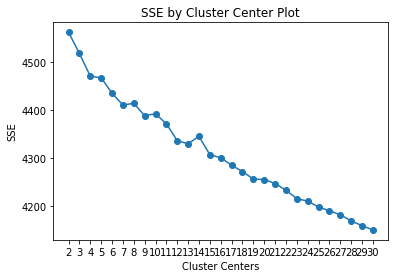

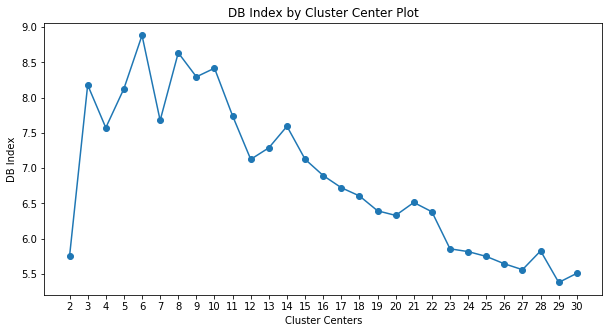

In [208]:
find_optimal_clusters(tfidf, 30)

In [ ]:
k_clusters = KMeans(n_clusters=29, random_state=20, verbose=1).fit_predict(tfidf)

In [216]:
def get_cluster_counts(clusters):
    counts = {}
    for i in np.stack([np.unique(clusters, return_counts=True)]).T:
        counts['Cluster {}'.format(i[0][0])] = i[1][0]
    for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True):
        print('{0}: {1}'.format(k, v))

In [217]:
get_cluster_counts(k_clusters)

Cluster 24: 1441
Cluster 18: 270
Cluster 19: 266
Cluster 5: 255
Cluster 11: 241
Cluster 3: 225
Cluster 21: 162
Cluster 10: 159
Cluster 2: 156
Cluster 8: 146
Cluster 7: 139
Cluster 25: 135
Cluster 9: 111
Cluster 15: 110
Cluster 27: 109
Cluster 28: 94
Cluster 12: 84
Cluster 6: 77
Cluster 23: 75
Cluster 0: 67
Cluster 20: 66
Cluster 1: 55
Cluster 22: 55
Cluster 26: 47
Cluster 13: 43
Cluster 17: 42
Cluster 4: 40
Cluster 14: 40
Cluster 16: 29


In [218]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    for i,r in df.iterrows():
        print('Cluster {}: '.format(i), 
              ', '.join([labels[t] for t in np.argsort(r)[-n_terms:][::-1]]))
        print(np.sort(r)[-n_terms:][::-1])
        print()

In [219]:
get_top_keywords(tfidf, k_clusters, vectorizer.get_feature_names(), 10)

Cluster 0:  interview, enjoy, turkey, tonight, kurds, drain, swamp, fight, syria, eastern
[0.1608173  0.1580931  0.1130203  0.10250911 0.09380333 0.07704311
 0.07391204 0.05217146 0.04957637 0.04314234]

Cluster 1:  market, stock, record, high, time, new, big, close, dow, economy
[0.28019532 0.27050653 0.15670105 0.12858292 0.06631459 0.05218851
 0.05183558 0.04293313 0.04154268 0.03804628]

Cluster 2:  thank, work, maga, hard, great, nice, steve, ohio, john, love
[0.84199053 0.0347523  0.03275078 0.02648612 0.02261966 0.02235115
 0.01146983 0.01133025 0.01097534 0.01056484]

Cluster 3:  democrat, impeachment, hoax, house, vote, party, scam, senate, republicans, republican
[0.16694247 0.14179206 0.08399438 0.04031074 0.03708487 0.03457085
 0.03434855 0.03040645 0.02719128 0.02513657]

Cluster 4:  america, great, make, thank, pennsylvania, support, incredible, world, ohio, hampshire
[0.61381165 0.30032812 0.2328258  0.04518924 0.02471838 0.01940107
 0.0191971  0.0185256  0.01781495 0.01

In [220]:
trump['k_cluster'] = k_clusters
trump.head()

,id,created_at,source,year,month,day,hour,day_of_week,week,is_reply,...,tb_polarity,tb_subjectivity,tb_orientation,tb_explanatory,vd_neg,vd_neu,vd_pos,vd_compound,vd_orientation,k_cluster
0,1256024228777857025,Fri May 01 00:54:46 +0000 2020,Twitter for iPhone,2020,4,30,20,4,17,False,...,-0.412500,0.825000,negative,subjective,0.373,0.627,0.000,-0.8786,negative,24
1,1256016249169084417,Fri May 01 00:23:04 +0000 2020,Twitter for iPhone,2020,4,30,20,4,17,False,...,1.000000,0.750000,positive,subjective,0.205,0.671,0.123,-0.4168,negative,24
2,1256013240896835585,Fri May 01 00:11:06 +0000 2020,Twitter for iPhone,2020,4,30,20,4,17,True,...,0.088889,0.397222,positive,objective,0.072,0.740,0.189,0.6885,positive,12
3,1256013239487549441,Fri May 01 00:11:06 +0000 2020,Twitter for iPhone,2020,4,30,20,4,17,False,...,0.541667,0.633333,positive,subjective,0.046,0.640,0.314,0.9439,positive,24
4,1255926261068763143,Thu Apr 30 18:25:29 +0000 2020,Twitter for iPhone,2020,4,30,14,4,17,False,...,0.250000,0.400000,positive,objective,0.000,1.000,0.000,0.0000,neutral,24


In [39]:
trump.to_pickle('temp.pkl') 

# Agglomerative Hierarchical Clustering

In [209]:
def find_optimal_clusters(data, max_n):
    iters = range(2, max_n+1)
    dbindex = []
    for i in iters:
        c = AgglomerativeClustering(n_clusters=i).fit(data.todense())
        db = davies_bouldin_score(data.todense(), c.labels_)
        dbindex.append(db)
        print('n_clusters = {0}, dbindex = {1}'.format(i, db))

    f, ax = plt.subplots(figsize=(10,5))
    ax.plot(iters, dbindex, marker='o')
    ax.set_xlabel('Cluster Count')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('DB Index')
    ax.set_title('DB Index Plot')

n_clusters = 2, dbindex = 1.0043699178923222
n_clusters = 3, dbindex = 1.6630571234985354
n_clusters = 4, dbindex = 1.736809854119495
n_clusters = 5, dbindex = 2.1878121599628253
n_clusters = 6, dbindex = 2.471446138037988
n_clusters = 7, dbindex = 2.174737069942854
n_clusters = 8, dbindex = 3.6496255949535596
n_clusters = 9, dbindex = 3.463331435674709
n_clusters = 10, dbindex = 3.6652434767373245
n_clusters = 11, dbindex = 3.5036004238208034
n_clusters = 12, dbindex = 3.848673812158786
n_clusters = 13, dbindex = 3.6488294905123984
n_clusters = 14, dbindex = 3.5162857302746153
n_clusters = 15, dbindex = 3.439525045423293
n_clusters = 16, dbindex = 4.3841014511162255
n_clusters = 17, dbindex = 4.242786941308539
n_clusters = 18, dbindex = 4.195662581573612
n_clusters = 19, dbindex = 4.149309072601683
n_clusters = 20, dbindex = 4.116462648245015
n_clusters = 21, dbindex = 3.9672246396631903
n_clusters = 22, dbindex = 3.8094603291340534
n_clusters = 23, dbindex = 3.741252095691359
n_clust

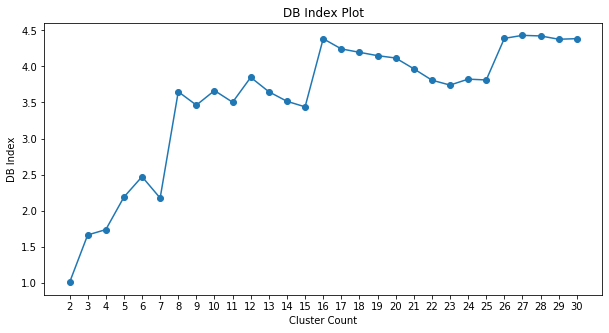

In [210]:
find_optimal_clusters(tfidf, 30)

In [221]:
a_clusters = AgglomerativeClustering(n_clusters=23).fit(tfidf.todense())

In [222]:
get_cluster_counts(a_clusters.labels_)

Cluster 0: 3110
Cluster 3: 554
Cluster 2: 175
Cluster 10: 161
Cluster 1: 114
Cluster 15: 106
Cluster 5: 63
Cluster 7: 47
Cluster 18: 42
Cluster 9: 40
Cluster 4: 39
Cluster 17: 39
Cluster 8: 36
Cluster 16: 31
Cluster 19: 30
Cluster 14: 26
Cluster 6: 24
Cluster 11: 23
Cluster 13: 19
Cluster 22: 18
Cluster 12: 16
Cluster 21: 16
Cluster 20: 10


In [223]:
get_top_keywords(tfidf, a_clusters.labels_, vectorizer.get_feature_names(), 10)

Cluster 0:  great, thank, people, democrat, good, country, big, president, just, new
[0.041183   0.02441698 0.02020446 0.0200019  0.01983919 0.01790405
 0.01740437 0.01733873 0.01530623 0.01488581]

Cluster 1:  whistleblower, schiff, adam, shifty, corrupt, politician, information, fraud, release, make
[0.19297737 0.19210518 0.09332679 0.07365503 0.05322639 0.0498934
 0.04586445 0.04359588 0.03759383 0.03753403]

Cluster 2:  china, reserve, tariff, rate, fed, dollar, federal, pay, product, country
[0.15541519 0.0672219  0.06663953 0.06242517 0.05916516 0.05826533
 0.05747537 0.04655113 0.04559092 0.04464963]

Cluster 3:  democrat, impeachment, president, trump, dem, mueller, hoax, say, party, want
[0.0684207  0.05223788 0.04731717 0.03648442 0.0329531  0.03202301
 0.0312664  0.02729242 0.02712736 0.02509146]

Cluster 4:  thank, maga, work, nice, hard, great, kag, news, soon, sooo
[0.35808599 0.26903645 0.20087432 0.18201367 0.15572228 0.11342933
 0.10473828 0.02301233 0.01906058 0.01826

In [224]:
trump['a_cluster'] = a_clusters.labels_
trump.head()

,id,created_at,source,year,month,day,hour,day_of_week,week,is_reply,...,tb_subjectivity,tb_orientation,tb_explanatory,vd_neg,vd_neu,vd_pos,vd_compound,vd_orientation,k_cluster,a_cluster
0,1256024228777857025,Fri May 01 00:54:46 +0000 2020,Twitter for iPhone,2020,4,30,20,4,17,False,...,0.825000,negative,subjective,0.373,0.627,0.000,-0.8786,negative,24,0
1,1256016249169084417,Fri May 01 00:23:04 +0000 2020,Twitter for iPhone,2020,4,30,20,4,17,False,...,0.750000,positive,subjective,0.205,0.671,0.123,-0.4168,negative,24,0
2,1256013240896835585,Fri May 01 00:11:06 +0000 2020,Twitter for iPhone,2020,4,30,20,4,17,True,...,0.397222,positive,objective,0.072,0.740,0.189,0.6885,positive,12,0
3,1256013239487549441,Fri May 01 00:11:06 +0000 2020,Twitter for iPhone,2020,4,30,20,4,17,False,...,0.633333,positive,subjective,0.046,0.640,0.314,0.9439,positive,24,0
4,1255926261068763143,Thu Apr 30 18:25:29 +0000 2020,Twitter for iPhone,2020,4,30,14,4,17,False,...,0.400000,positive,objective,0.000,1.000,0.000,0.0000,neutral,24,0


In [225]:
trump.to_csv('trump_clustered_new.csv', sep=',', encoding='utf-8', index=False)